<a href="https://colab.research.google.com/github/ahmadryan/MLTSA_RQudsi/blob/master/HW9_RQudsi/Assignemnt9_MLTSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and run 2 models on these feautes: a cluster model, and a classification tree. 

To limit confusion I removed the first part of the notebook. You can find it in https://github.com/fedhere/MLTSA_FBianco/tree/master/HW5 in the solution notebook


In [414]:
import pandas as pd
import numpy as np
import pylab as pl
from numpy import *
%pylab inline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [4]:
cd data/

/content/gdrive/My Drive/data


In [415]:
!pwd

/content/gdrive/My Drive/data


In [416]:
# NOTE::: this is not a reproducible way to do it!!!!!! this would cost points

lcvs = pd.read_csv("plasticc_train_lightcurves.csv.gz")

# The Zenodo data include 1.4 million datapoints. 
## -- I am subsampling the data to develop the code 
# by using only the first 10000 datapoints (lcvs[:10000])
## -- When I am done I will run this on the larger dataset (commenting out #[:10000])
## note that I am choosing the first N=1000, as opposed to 1 every 100 or whatever 
## because there are 6 time series per obects in 6 filters (colors)

lcvs = lcvs#[:10000]
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [417]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [418]:
# Find out the minimum length of days among all the objects
max_ind = 1.e6
for ob_id in lcvs.object_id.unique():
    day_len = max(lcvs.mjd[lcvs.object_id==ob_id]) - min(lcvs.mjd[lcvs.object_id==ob_id])
    if(day_len < max_ind ):
        max_ind = day_len
        print(max_ind)

873.7903000000006
848.8197999999975
847.783500000005
838.6699000000008
813.9032000000007
788.9944000000032
765.9035000000003
755.9755000000005


In [0]:
def nanmean_func(x):
    return nanmean(x)

# Using Gaussian processing to extrapolate the data

In [0]:
def predict_df( df, obid) :

    '''The function takes a dataframe and an object ID and retunrs another 
    dataframe which has equally sampled data points in time. The interpolation 
    between times of observations are done using Gaussian process
    df = Input DataFrame.
    obid = Object ID (the object for which data interpolation needs to be done)
    Must be an integer.
    '''
    df_r = pd.DataFrame()

    for band_num in range(6) :
        # define the new dataframe
        df_n = df[df.object_id==84716]

        # Groupby the passband data
        df_n_g = df_n.groupby(["passband"])

        # Stack and then unstack the data so that he passband and 'mjd' are the
        # two indices
        df_n_g = df_n.reset_index().set_index(['mjd','passband']).stack(
            ).unstack([1,2])
        #print(df_n.keys(), df_n_g.keys())
        # Re-define the indices such that the minimum value is zero which
        # corresponds to to the first day of observation
        new_index = (df_n_g.index - df_n_g.index.min()).values
        df_n_g.drop('index', axis=1, level=1, inplace=True)
        df_n_g.index = new_index[:]

        dffn = df_n_g.reset_index().set_index(pd.to_datetime(df_n_g.index, unit='D',
                   origin=pd.Timestamp('1960-01-01')), append=False)
        dff_r = dffn.resample('1D').apply(nanmean_func)
#
        final_indices = arange(max_ind)
        dff_rn = dff_r[0:int(max_ind)]
        dff_rn.index = final_indices[:-1]
        dff_rn.drop('index', axis=1, inplace=True)
        df_n_g = dff_rn
        # Add noise and fit to data using Maximum Likelihood Estimation of the 
        # parameters
        kernel = RBF(10, (1e-2, 1e2)) 
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,
                                 alpha=0) # this is the variance of the data)

        gp_normed = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,
                                alpha=0) # this is the variance of the data)

        # Define the time of all observations in the proper format
        t_o = df_n_g.index[~isnan(df_n_g[band_num,'flux'])]
        t_original = atleast_2d(t_o).T

        #Define the times at which the observation is to be predicted in the 
        # proper format
        t_p = atleast_2d(linspace(df_n_g.index.min(), df_n_g.index.max(), 
                                  len(df_n_g.index))).T
        t_predict = atleast_2d(t_p)

        # Find the indices where the flux value is not NaN
        ind = ~isnan(df_n_g[band_num,'flux'])

        flux_val = df_n_g[band_num,'flux'][ind]
        flux_val_err = df_n_g[band_num,'flux_err'][ind]

        #flux_val_normed = df_n_g[band_num,'fluxnormed'][ind]
        #flux_val_normed_err = df_n_g[band_num,'fluxnormed_err'][ind]

        gp.fit(t_original, flux_val)
        #gp_normed.fit(t_original, flux_val_normed)

        # Make the prediction on the time axis (ask for MSE as well)
        y_predict, sigma = gp.predict(t_predict, return_std=True)
        #y_normed_predict, sigma_normed = gp_normed.predict(t_predict, return_std=True)

        if(df_r.empty) :
            df_r = pd.DataFrame(index=df_n_g.index)

        df_r[band_num, obid, 'flux'] = y_predict
        #df_r[band_num, obid, 'fluxnormed'] = y_normed_predict
        df_r[band_num, obid, 'flux_err'] = sigma
        #df_r[band_num, obid, 'fluxnormed_err'] = sigma_normed

    ## Plot the function, the prediction and the 95% confidence interval based on
    ## the MSE
    #pl.figure()
    #pl.plot(t_original, flux_val, '.', color='IndianRed', markersize=10, label='Observations')
    #pl.errorbar(t_original, flux_val, yerr=flux_val_err, fmt='.', color='k')
    #pl.plot(t_predict, y_predict, 'k-', label='Prediction')
    #pl.fill_between(t_predict.ravel(), y_predict - sigma, y_predict + sigma,
    #        alpha=.3, color='k')
    #pl.xlabel('t')
    #pl.ylabel('f(t)')
    #pl.title("fit with noise does not require exact fit to data");
#
    #    pl.figure()
    #pl.plot(t_original, flux_val, '.', color='IndianRed', markersize=10, label='Observations')
    #pl.errorbar(t_original, flux_val, yerr=flux_val_err, fmt='.', color='k')
    #pl.plot(t_predict, y_predict, 'k-', label='Prediction')
    #pl.fill_between(t_predict.ravel(), y_predict - sigma, y_predict + sigma,
    #        alpha=.3, color='k')
    #pl.xlabel('t')
    #pl.ylabel('f(t)')
    #pl.title("fit with noise does not require exact fit to data");

    # Reset the index to a datetime index to make resampling easier
    #dffn = df_r.reset_index().set_index(pd.to_datetime(df_r.index, unit='D',
    #           origin=pd.Timestamp('1960-01-01')), append=False)
    #dff_r = dffn.resample('1D').apply(nanmean_func)
#
    #final_indices = arange(max_ind)
    #dff_rn = dff_r[0:int(max_ind)]
    #dff_rn.index = final_indices[:-1]
    #dff_rn.drop('index', axis=1, inplace=True)
    return df_r

In [450]:
df_84716_n = predict_df(lcvs, 8716)

1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64
1960-01-01 00:00:00.000    0.0000
1960-01-01 21:54:17.280    0.9127
Name: (index, ), dtype: float64


RecursionError: ignored

In [436]:
df_84716_n[0:20]

,"(0, 8716, flux)","(0, 8716, flux_err)","(1, 8716, flux)","(1, 8716, flux_err)","(2, 8716, flux)","(2, 8716, flux_err)","(3, 8716, flux)","(3, 8716, flux_err)","(4, 8716, flux)","(4, 8716, flux_err)","(5, 8716, flux)","(5, 8716, flux_err)"
0.0,7.612425e-01,0.087257,-1.831364,0.684916,0.777847,0.692627,-0.629806,0.526308,0.636194,0.622045,-4.741261,0.845265
1.0,-3.271215e-02,0.999978,-1.082443,0.063681,0.323248,0.066513,1.165907,0.032858,-0.779400,0.047665,-1.887727,0.137329
2.0,-7.595710e-11,1.000000,-0.115716,0.069027,2.487451,0.072144,-0.424060,0.034665,-0.105702,0.051141,3.460806,0.158333
3.0,-6.092174e-26,1.000000,-1.496973,0.245683,5.078370,0.254555,-3.802987,0.143761,2.195929,0.194633,-7.687020,0.419816
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,-3.419799e-48,1.000000,0.167862,0.947157,0.670595,0.950673,-1.484151,0.865038,0.041235,0.917818,-0.386482,0.991571
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,1.914348e-71,1.000000,0.085091,0.534981,0.377926,0.540612,1.064928,0.443107,0.137488,0.495629,-2.540440,0.648575
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Compute features based on the new dataset

In [0]:
#Various small functions for feature calculations

from scipy import stats
from statsmodels.formula.api import ols

def moment_computation(x, moment_order):
    '''Define a function to compute moment of a distribution given the 
    distribution and order of moment
    '''
    return stats.moment(x, moment = moment_order)

def normed_max(x) :
    return max(( x -  mean(x) ) /std(x))

def normed_min(x) :
    return min(( x -  mean(x) ) /std(x))

def linfit(x):
    pars = np.polyfit(range(len(x)), x, 1)
    return pars

def quadfit(zz):
    x= pd.DataFrame()
    x['t'] = array(zz.index)
    x['flux'] = zz.values
    m1 = ols(formula='flux~t + 1', data=x).fit()
    m2 = ols(formula='flux~pow(t, 2) + t + 1', data=x).fit()
    pars = m2.llf, m1.llf, np.sign(m2.params[1])
    return pars

In [422]:
%%time
feature_list = ['mean', 'std', 'variance', 'skewness', 'kurtosis', 'maxs', 
           'mins','max_std', 'min_std', 'slopes', 'intercepts', 
           'll1', 'll2', 'll3']

object_id_list = sort(lcvs.object_id.unique())
passband_list = sort(lcvs.passband.unique())
idx = object_id_list
col = pd.MultiIndex.from_product([passband_list, feature_list])
df_features = pd.DataFrame( columns=col, index=idx)

count = 0

for object_id in object_id_list[0:2] :

    print(object_id)
    df = predict_df(lcvs, object_id)

    for col_idx in linspace(0,len(df_features.columns)-13, 6, dtype=int):
        pass_band = df_features.columns[col_idx][0]

        df_features[col[col_idx]][count] = mean(df[(pass_band, object_id, 'flux')])
        df_features[col[col_idx+1]][count] = std(df[(pass_band, object_id, 'flux')])
        df_features[col[col_idx+2]][count] = moment_computation(df[(pass_band, object_id, 'flux')], 
                                                       moment_order=2 )
        df_features[col[col_idx+3]][count] = moment_computation(df[(pass_band, object_id, 'flux')], 
                                                       moment_order=3 )
        df_features[col[col_idx+4]][count] = moment_computation( df[(pass_band, object_id, 'flux')],
                                                       moment_order=4 )
        df_features[col[col_idx+5]][count] = max(df[(pass_band, object_id, 'flux')])
        df_features[col[col_idx+6]][count] = min(df[(pass_band, object_id, 'flux')])
        df_features[col[col_idx+7]][count] = normed_max(df[(pass_band, object_id, 'flux')])
        df_features[col[col_idx+8]][count] = normed_min(df[(pass_band, object_id, 'flux')])
        linfits = linfit(df[(pass_band, object_id, 'flux')])
        df_features[col[col_idx+9]][count] = linfits[0]
        df_features[col[col_idx+10]][count] = linfits[1]

        #ols = quadfit(df[(pass_band, object_id, 'flux')]))
        #print(ols)
        #df_features[col[col_idx+11]][count] = ols[0]
        #df_features[col[col_idx+12]][count] = ols[1]
        #df_features[col[col_idx+13]][count] = ols[2]

        count += 1

df_features.to_pickle('all_features.p')

615


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


713


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 1.26 s, sys: 676 ms, total: 1.94 s
Wall time: 1.25 s


In [423]:
df_features.head()

0                                  ...      5                          
          mean  std variance skewness kurtosis  ... slopes intercepts  ll1  ll2  ll3
615        NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
713        NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
730        NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
745        NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
1124       NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
...        ...  ...      ...      ...      ...  ...    ...        ...  ...  ...  ...
130739978  NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
130755807  NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
130762946  NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
130772921  NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN
130779836  NaN  NaN      NaN      NaN      NaN  ...    NaN        NaN  NaN  NaN  NaN

[7848 rows x 84 columns]

In [44]:
df_features.head()

passband          0                          ...          5                
               mean        std     variance  ...        ll1        ll2  ll3
object_id                                    ...                           
615       -3.254554  83.944735  6934.865833  ... -76.917754 -77.386461 -1.0
713       -2.720398   7.113509    49.879128  ... -65.167686 -65.424297 -1.0
730       -0.048080   1.828872     3.298318  ... -66.518080 -67.853917  1.0
745        1.797523   4.374445    18.869993  ... -64.783463 -77.536999 -1.0
1124       0.660948   2.360084     5.481586  ... -76.526495 -76.666778  1.0

[5 rows x 90 columns]

In [45]:
df_features.shape

(7848, 90)

In [0]:
df_features_old = df_features.copy()
allfeatures = df_features.copy()

In [39]:
metadata = pd.read_csv("plasticc_train_metadata.csv.gz")
metadata

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.7188,-14.9403,0,0.000,0.000,0.000,-9.000,0.013,65,65,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,18232,26.4,267.6,742.8,3295.1,6047.5,7955.2
7844,130755807,120.1013,-62.6967,0,0.172,2.561,1.115,46.611,0.136,90,90,1,0.172,39.595,-0.001,-12.8,0.0,0.0,60056.809,14934,0.0,0.0,0.0,0.0,0.0,0.0
7845,130762946,203.1081,-55.6821,0,0.000,0.000,0.000,-9.000,0.430,16,16,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,47805,83.8,1124.7,1445.1,1191.2,848.9,382.5
7846,130772921,79.1016,-35.5018,0,0.000,0.000,0.000,-9.000,0.034,65,65,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,22240,1.9,14.4,49.4,244.3,534.8,897.2


In [46]:
allfeatures = allfeatures.merge(metadata[["object_id", "decl", "ddf_bool", "hostgal_photoz", 
                                          "hostgal_photoz_err", "target"]], on=['object_id']).drop("object_id", axis=1)
allfeatures.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(0, mean)","(0, std)","(0, variance)","(0, skewness)","(0, kurtosis)","(0, maxs)","(0, mins)","(0, max_std)","(0, min_std)","(0, median_std)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll2)","(0, ll3)","(1, mean)","(1, std)","(1, variance)","(1, skewness)","(1, kurtosis)","(1, maxs)","(1, mins)","(1, max_std)","(1, min_std)","(1, median_std)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, mean)","(2, std)","(2, variance)","(2, skewness)","(2, kurtosis)","(2, maxs)","(2, mins)","(2, max_std)","(2, min_std)","(2, median_std)",...,"(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, mean)","(4, std)","(4, variance)","(4, skewness)","(4, kurtosis)","(4, maxs)","(4, mins)","(4, max_std)","(4, min_std)","(4, median_std)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, mean)","(5, std)","(5, variance)","(5, skewness)","(5, kurtosis)","(5, maxs)","(5, mins)","(5, max_std)","(5, min_std)","(5, median_std)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,-3.254554,83.944735,6934.865833,72665.792850,7.433032e+07,125.182808,-116.913223,1.530023,-1.353970,-0.080537,0.005676,-0.175947,-84.013092,-88.218652,-1.0,-385.699911,601.787302,355904.026224,8.593916e+07,2.215166e+11,660.626343,-1100.440063,1.738698,-1.187696,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,203564.138816,3.040627e+07,6.659406e+10,611.984558,-681.858887,1.639411,-1.203442,-0.289021,...,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,83681.162283,4.717542e+06,1.036570e+10,381.953735,-422.184509,1.500696,-1.255057,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,85370.493377,3.041829e+06,1.049535e+10,378.188141,-422.815094,1.443920,-1.273376,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,-2.720398,7.113509,49.879128,89.634243,4.907398e+03,14.509829,-14.735178,2.422184,-1.689009,-0.052914,-0.041433,1.429423,-45.801483,-49.801325,-1.0,-1.019804,5.712334,32.048070,-1.551087e+01,1.944373e+03,9.129021,-11.715749,1.776651,-1.872430,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,32.706748,-4.127475e+00,1.935955e+03,10.529041,-10.067919,1.962189,-1.607018,0.117188,...,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,40.316483,-1.597455e+01,2.938985e+03,9.827934,-12.286801,1.674452,-1.777206,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,49.427194,7.377121e+01,5.294322e+03,14.770886,-14.211164,2.335056,-1.750333,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,-0.048080,1.828872,3.298318,2.093148,3.655013e+01,5.942166,-3.459960,3.275377,-1.865565,0.039463,-0.001798,0.063840,-101.249926,-101.606902,-1.0,0.141057,1.807229,3.203266,2.623669e+00,3.870188e+01,5.693109,-3.393080,3.072136,-1.955556,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,30.313471,3.864890e+02,6.926529e+03,20.994711,-2.848838,3.344527,-0.944280,-0.343392,...,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,112.462234,2.936931e+03,1.060595e+05,41.159981,-5.836310,3.440716,-0.947219,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,174.276892,3.751336e+03,1.860606e+05,47.310059,-19.159811,3.207938,-1.777517,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,1.797523,4.374445,18.869993,162.368381,2.575248e+03,18.014029,-3.874349,3.707100,-1.296592,-0.169349,-0.013089,0.464675,-88.423048,-100.184915,-1.0,5.717394,25.964659,662.124902,1.161627e+05,2.162844e+07,192.244293,-3.618410,7.183876,-0.359558,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1003.075853,1.758302e+05,3.606109e+07,220.795212,-2.159753,6.605035,-0.371465,-0.290606,...,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,1074.034376,1.190633e+05,1.781661e+07,1

In [47]:
print("My feature space is {:2} features (columns)".format(len(allfeatures.columns)))

My feature space is 95 features (columns)


In [48]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 1 infinity entries


In [0]:
np.isfinite(allfeatures).sum()

(0, mean)             7848
(0, std)              7848
(0, variance)         7848
(0, skewness)         7848
(0, kurtosis)         7848
                      ... 
decl                  7848
ddf_bool              7848
hostgal_photoz        7848
hostgal_photoz_err    7848
target                7848
Length: 95, dtype: int64

In [0]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape

((7848, 90), (7847, 90))

In [0]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape

((7848, 95), (7848, 94))

In [0]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99)

((7848, 95),        (0, mean)     (0, std)  ...  hostgal_photoz_err  target
 0      -3.254554    83.944735  ...               0.000      92
 1      -2.720398     7.113509  ...               0.255      88
 2      -0.048080     1.828872  ...               0.016      42
 3       1.797523     4.374445  ...               1.152      90
 4       0.660948     2.360084  ...               0.018      90
 ...          ...          ...  ...                 ...     ...
 7843    1.286655    15.998517  ...               0.000      65
 7844   24.635243    79.713932  ...               1.115      90
 7845   -0.282914    46.605187  ...               0.000      16
 7846    3.374208    14.420201  ...               0.000      65
 7847  812.700937  2120.766511  ...               0.000       6
 
 [7848 rows x 95 columns])

In [0]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# PART II: I already guided you  through some of these tasks, but sort of "blindly". Start from here for part 2: we will reperform some of the tasks more thoughtfully (and correctly) and you will apply both clustering and classification to the PLASTiCC challenge data

# PART IIA : Preprocessing


## Task II.1: Preprocess your features by scaling them along the feature axis

Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1 - we will talk about it in class but make sure you deliver in this notebook the scaled features as below. Save the original mean and standard deviation for all features

**Deliverable II.1: the means and standard deviation arrays and the scaled features array**

In [0]:
allfeatures

In [0]:
allfeatures

,"(0, mean)","(0, std)","(0, variance)","(0, skewness)","(0, kurtosis)","(0, maxs)","(0, mins)","(0, max_std)","(0, min_std)","(0, median_std)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll3)","(1, mean)","(1, std)","(1, variance)","(1, skewness)","(1, kurtosis)","(1, maxs)","(1, mins)","(1, max_std)","(1, min_std)","(1, median_std)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, mean)","(2, std)","(2, variance)","(2, skewness)","(2, kurtosis)","(2, maxs)","(2, mins)","(2, max_std)","(2, min_std)","(2, median_std)","(2, slopes)",...,"(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, mean)","(4, std)","(4, variance)","(4, skewness)","(4, kurtosis)","(4, maxs)","(4, mins)","(4, max_std)","(4, min_std)","(4, median_std)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, mean)","(5, std)","(5, variance)","(5, skewness)","(5, kurtosis)","(5, maxs)","(5, mins)","(5, max_std)","(5, min_std)","(5, median_std)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,-3.254554,83.944735,6.934866e+03,7.266579e+04,7.433032e+07,125.182808,-116.913223,1.530023,-1.353970,-0.080537,0.005676,-0.175947,-84.013092,-1.0,-385.699911,601.787302,3.559040e+05,8.593916e+07,2.215166e+11,660.626343,-1100.440063,1.738698,-1.187696,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,2.035641e+05,3.040627e+07,6.659406e+10,611.984558,-681.858887,1.639411,-1.203442,-0.289021,0.017676,...,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,8.368116e+04,4.717542e+06,1.036570e+10,381.953735,-422.184509,1.500696,-1.255057,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,8.537049e+04,3.041829e+06,1.049535e+10,378.188141,-422.815094,1.443920,-1.273376,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,-2.720398,7.113509,4.987913e+01,8.963424e+01,4.907398e+03,14.509829,-14.735178,2.422184,-1.689009,-0.052914,-0.041433,1.429423,-45.801483,-1.0,-1.019804,5.712334,3.204807e+01,-1.551087e+01,1.944373e+03,9.129021,-11.715749,1.776651,-1.872430,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,3.270675e+01,-4.127475e+00,1.935955e+03,10.529041,-10.067919,1.962189,-1.607018,0.117188,-0.053887,...,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,4.031648e+01,-1.597455e+01,2.938985e+03,9.827934,-12.286801,1.674452,-1.777206,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,4.942719e+01,7.377121e+01,5.294322e+03,14.770886,-14.211164,2.335056,-1.750333,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,-0.048080,1.828872,3.298318e+00,2.093148e+00,3.655013e+01,5.942166,-3.459960,3.275377,-1.865565,0.039463,-0.001798,0.063840,-101.249926,-1.0,0.141057,1.807229,3.203266e+00,2.623669e+00,3.870188e+01,5.693109,-3.393080,3.072136,-1.955556,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,3.031347e+01,3.864890e+02,6.926529e+03,20.994711,-2.848838,3.344527,-0.944280,-0.343392,0.026905,...,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,1.124622e+02,2.936931e+03,1.060595e+05,41.159981,-5.836310,3.440716,-0.947219,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,1.742769e+02,3.751336e+03,1.860606e+05,47.310059,-19.159811,3.207938,-1.777517,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,1.797523,4.374445,1.886999e+01,1.623684e+02,2.575248e+03,18.014029,-3.874349,3.707100,-1.296592,-0.169349,-0.013089,0.464675,-88.423048,-1.0,5.717394,25.964659,6.621249e+02,1.161627e+05,2.162844e+07,192.244293,-3.618410,7.183876,-0.359558,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1.003076e+03,1.758302e+05,3.606109e+07,220.795212,-2.159753,6.605035,-0.371465,-0.290606,-0.003878,...,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,

In [0]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

In [0]:
featuremeans = allfeatures.mean().values
featurestd = allfeatures.std().values
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observcations {}, features {}, means {}, standard deviations {}".format(
    *X.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays [ 3.92737631e+01  2.18255899e+02  1.17402466e+08  9.32087443e+13
  3.41670025e+20  5.23882191e+02 -2.47707666e+02  2.25065757e+00
 -1.62773232e+00 -7.30978852e-02  3.24319722e-04  6.37471557e-03
 -3.23453304e+01  8.15494393e-03  2.96187944e+01  1.88291251e+02
  1.26600038e+06  3.16596717e+10  4.75957697e+15  3.87999042e+02
 -1.88841777e+02  2.54866973e+00 -1.30848432e+00 -1.58191816e-01
 -4.47031168e-03  2.58871203e-02 -2.76154050e+01 -2.96436596e+01
  5.37716616e-02  4.29330082e+01  2.04791323e+02  3.54331510e+06
  1.68105011e+11  8.87945300e+16  4.84962221e+02 -2.16683247e+02
  3.05009638e+00 -1.25648291e+00 -2.01574134e-01 -2.48675518e-03
  3.19192091e-02 -3.65387768e+01 -3.96869617e+01  8.53720693e-02
  4.42794190e+01  1.98862866e+02  4.83654718e+06  2.76767695e+11
  1.82763818e+17  4.76626366e+02 -1.95807404e+02  2.94933990e+00
 -1.30670126e+00 -1.94071059e-01 -1.69153033e-03  2.11262820e-02
 -3.56182235e+01 -3.88739946e+01  6.85524975e-02

In [0]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [ 5.43228391e-18 -3.62152261e-18  1.81076130e-18 -2.71614196e-18
 -3.62152261e-18 -2.71614196e-18  3.62152261e-18  5.79443617e-17
  0.00000000e+00  2.17291357e-17  1.08645678e-17  7.24304522e-18
  0.00000000e+00  6.51874070e-17  5.88497424e-18 -4.07421293e-18
  6.33766456e-18  3.62152261e-18 -2.71614196e-18  5.43228391e-18
  1.26753291e-17  0.00000000e+00  3.62152261e-17 -1.08645678e-17
  4.52690326e-18 -1.04118775e-17  1.15888723e-16  5.79443617e-17
 -2.53506583e-17 -3.62152261e-18  1.00723598e-17  0.00000000e+00
 -4.52690326e-18  1.81076130e-18 -4.52690326e-19  5.43228391e-18
  1.44860904e-17  1.62968517e-17  3.62152261e-18  1.17699485e-17
 -3.16883228e-18 -5.79443617e-17  0.00000000e+00  1.23131769e-16
  1.81076130e-18 -4.97959359e-18  1.81076130e-18  0.00000000e+00
 -9.05380652e-19  1.81076130e-18 -1.26753291e-17  2.89721809e-17
  1.44860904e-17 -1.44860904e-17 -1.08645678e-17 -2.26345163e-18
  0.00000000e+00 -5.79443617e-

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "



# Task II.2: You already did this in part I: you do not have to do it again if you are satisfied with what you did, but retun this since you redid the scaling of the features: Visualize a large dimensional feature space to plan the analysis and produce a 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE: t-distributed Stocastic Neighbourhood Embedding
It project N-dimensional data on a 2-dimensional surface preserving the N-dimensional distance. If thre is structure in the feature space, it should show. If there is structure in feature space, clustering is a promising technique.


In [0]:
from sklearn.manifold import TSNE

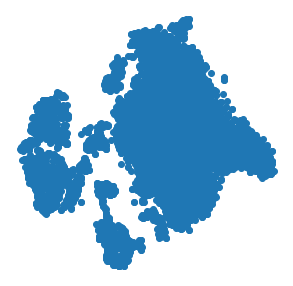

CPU times: user 2min 20s, sys: 290 ms, total: 2min 20s
Wall time: 1min 18s


In [0]:
%%time

X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.axis('off')
pl.show()

Figure1:The 2D projection of the ~90-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising:t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian pairwise distances existing in the higher dimensional parameter space. 7 clusters are visible in the figure.

We have to assure that the clusters map to the target variable tho. So I will redo the plot colorcoded by target variable

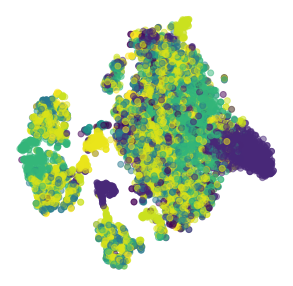

In [0]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.axis('off')
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y))], alpha=0.5);

Figure 2: The purity of the sample is not good in the t-SNE projection against the target variable. The colors are mixed in most t-SNE clusters, the highest purity is achieved near the center of the projected feature space. **This is not a particularly promising situation**

Does this map better on other features in the metadata?



**Deliverable II.2: make your version of the plot below, and discuss your own result, which will likely be somewhast different from mine. Do you see any other insightful mapping of the features in the t-SNE projection?**

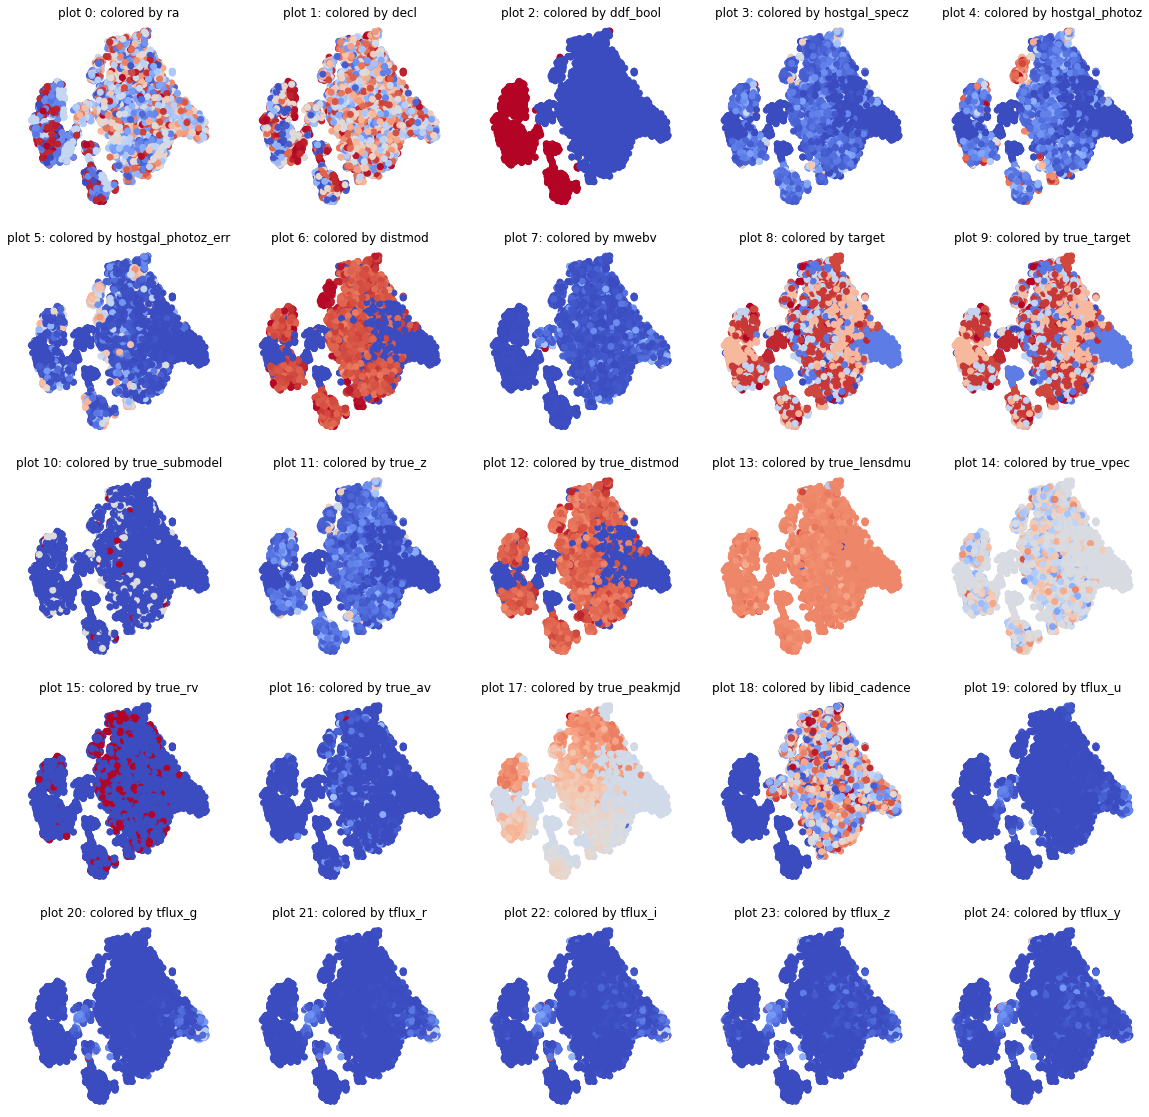

In [0]:
fig = pl.figure(figsize=(20,20))
# note: I am avoiding the first column of metadata which is the object identifier
for i, col in enumerate(metadata.columns[1:]):
    ax = fig.add_subplot(5,5,i+1)
    v = metadata[col].astype(float)
    ax.set_title("plot %d: colored by %s"%(i,col))
    ax.scatter(X_embedded[:,0], X_embedded[:,1],  
               color=[pl.cm.coolwarm(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    ax.axis('off')

    #pl.show()

Figure 3: The feature space is projected on a 2D plane via t-SNE method, and the points are colorcoded by the value of all metadata: this includes features used in the feature space as well as features that are not used in the feature space. The fueature space t-SNE projection does not map the metadata, except for the survey: **row 1 and column 3** the data includes a DeepDrillingField survey and a regular survey (called wide-fast-deep) which include different observation strategy decisions (data collection strategy). Those are obviously affecting the data features this the clear split of the cluster in row 1 column 3.  (The deep drilling fields are special regions of the sky that would be observed more frequently, a whole bunch of times in one night. So even if an object were the same kind of object the extracted features could be very different!).

Most other features map the t-SNE projection more poorly. 


# PART IIB : Clustering 
## cluster the data using Agglomerative and DBscan. 
    


In [0]:
from sklearn.cluster import AgglomerativeClustering

Here is how I could cluster the data using the Euclidian distance with Agglomeratie Clustering stoopping the algorithm at 3 clusters. The Eucledian distance is the default for this (and most other) clustering algorithms implemented in sklearn. 

- Note: I can use the Eucledian distance **because** I preprocessed the feature space and all features have the same standard deviation!* 

- Note: the AgglemerativeClustering implementation in python allows to specify the number of clusters (I will use 3): the agglomeration will stop there for efficiency, this is not the same as having to specify the number of clusters in k-means, where the result depends on the number of clusters. In agglomerative clustering the following clusters would be segmentations of the first 2. 



elements in cluster 0 5944
elements in cluster 1 1
elements in cluster 2 1903



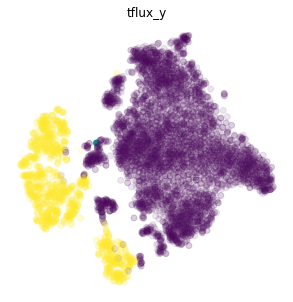

In [0]:
clustering = AgglomerativeClustering(n_clusters=3).fit(X_scaled)

for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

Figure 4: clustering the 90 dimensional feature space based on Agglomerateive  clustering algorithm with Eucledian distance into 3 clusters. There are 2 clusters of several observations, mapping excellently to the t-SNE projection. One cluster of one indicates the presence of an outlier

## TASK II.3:  Use AgglomerativeClustering in sklearn allows to select the number of cluster, run AgglomearativeCLustering with 2,3,4,5,6 clusters with Eucledian distance. Comment on the results.

**Deliverable II.3: plot the clusters obtained with AgglomerativeClustering with n_custer 2...6 and Eucledian distance, and comment on the result (mapping on t-SNE, outliers, consistence between the results obtained with different number of clusters)**


elements in cluster 0 7847
elements in cluster 1 1



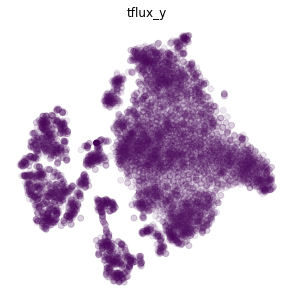

elements in cluster 0 5944
elements in cluster 1 1
elements in cluster 2 1903



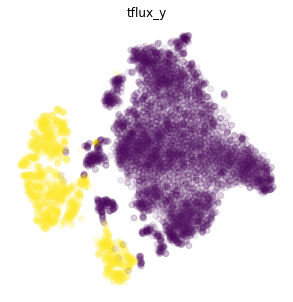

elements in cluster 0 5943
elements in cluster 1 1
elements in cluster 2 1903
elements in cluster 3 1



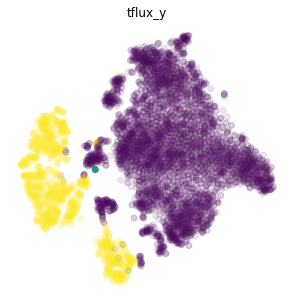

elements in cluster 0 5187
elements in cluster 1 756
elements in cluster 2 1903
elements in cluster 3 1
elements in cluster 4 1



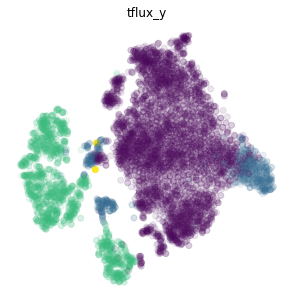

In [0]:
for n in range(2,6):
    clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)

    for j in range(n):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
    print()
    pl.figure(figsize=(5,5))
    pl.title(col)

    #using a color map normalized according to the number of clusters:
    # for 3 clusters vmin=0, vmax=2
    colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=j-1)(c))
                                                         for c in clustering.labels_])
    # changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
    alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 2 else 1.0 for j in clustering.labels_])
    # setting the alpha channel by replacing the default of the colormap which is 1
    colors[:,3] = alpha
    
    pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
                color=colors);
    pl.axis('off')
    pl.show()

Figure 5: Clustering the 90 dimensional feature space based on Agglomerateive  clustering algorithm with Eucledian distance into various cluster sizes ranging from 2 to 5. For the two cluster cases, there is one outlier, whereas for all the other cases, there are always at least 2 clusters which have only single data points indicating the presence of two outliers in the t-SNE projection.

## let's take a look at outliers: in the AgglomerativeClustering (n_cluster=2) there is one outlier**

## Extra Credit 1: If you have clusters where you have single object in a cluster (e.g. in my Agglomerative Cluastering with n_cluster=2) try and figure out how why the object that is an outlier and isolated by your clustering model. 

I plotted all objects of the same type as the outlier in the 3-clusters result, but this was not very insightful. Can you do better?

## TASK II.4 what happens if I change the distance metric?

Create a new metric: precompute the braycurtis metric with scipy.spatial.distance.cdist and pass it to the accolmerative clustering with n_clusters=3 and affinity='precomputed'. Describe the result. Look online, on the documentation of scipy and on the any statistical resources (wikipedia has great pages on this) to describe the braycurtis distance.

**Deliverable: make a plot of the t-SNE projection colorcoded by the cluster obtained with the precomputed braycurtis distance and comment on whether it is consistent with the Eucledian distance clustering result.**

In [0]:
from scipy.spatial.distance import cdist

In [0]:
clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)

In [0]:
dist = cdist(X_scaled, X_scaled, metric='braycurtis')
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))

elements in cluster 2 1762
elements in cluster 1 4010
elements in cluster 0 2076


elements in cluster 0 2076
elements in cluster 1 4010
elements in cluster 2 1762



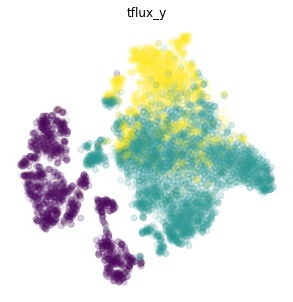

Figure: clustering the 90 dimensional feature space based on Agglomerateive Clustering algorithm with Eucledian distance into 3 clustersThere are 2 clusters of several observations, mapping excellently to the t-SNE projectionOne cluster of one indicates the presence of an outlier


In [0]:
for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

Figure 6: Clustering the 90 dimensional feature space based on Agglomerative Clustering algorithm with Bray–Curtis dissimilarity into 3 clusters. All the three clusters show comparable number of elements in them, however one cluster is very well separated from the other two which show significant overlap with very diffused boundary between them.

## Extra Credit II : Also cluster the original, not scaled features but use the Mahalanobis distance, which takes into account the variance of a feature and comment on the result. Is it consistent with the result using Eucledian distance on the scaled feature space

In [0]:
from scipy.spatial.distance import mahalanobis as mahalanobis

In [0]:
mahalanobis?

In [0]:
clustering = AgglomerativeClustering(n_clusters=3).fit(X)

In [0]:
X.shape, X_scaled.shape

((7848, 93), (7848, 93))

In [0]:
X

array([[-3.25e+00,  8.39e+01,  6.93e+03, ...,  1.00e+00,  0.00e+00,
         0.00e+00],
       [-2.72e+00,  7.11e+00,  4.99e+01, ...,  1.00e+00,  1.63e+00,
         2.55e-01],
       [-4.81e-02,  1.83e+00,  3.30e+00, ...,  1.00e+00,  2.26e-01,
         1.60e-02],
       ...,
       [-2.83e-01,  4.66e+01,  2.00e+03, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [ 3.37e+00,  1.44e+01,  1.93e+02, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [ 8.13e+02,  2.12e+03,  4.15e+06, ...,  0.00e+00,  0.00e+00,
         0.00e+00]])

In [0]:
V = linalg.inv(X)

LinAlgError: ignored

In [0]:
dist = mahalanobis(X_scaled, X_scaled, VI=V)
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)

NameError: ignored

In [0]:
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))

dist = cdist(X_scaled, X_scaled, metric='braycurtis')
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))

In [0]:
for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

In [0]:
sklearn.cluster.DBSCAN?

## Extra Credit III: What happens if you change clustering strategy?
Cluster the features with DBScan. DBScan is the most cited clustering method. It is density based clustering: it allows you to specify a distance metric, and a minimum distance and number of neightbours within that distance for a point to be considered part of a cluster. Choose and justify your choice on the following parameters 
- eps: the maximum distance between two observations to be in the same cluster
- min_sample: the minimum number of neighbours a cluster needs to have to be a cluster (and not an outlier)



elements in cluster 0 0
elements in cluster 1 0
elements in cluster 2 0



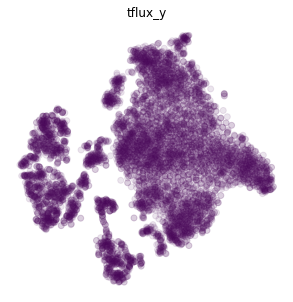

In [0]:
DBclustering = sklearn.cluster.DBSCAN(eps=1, min_samples=100, metric='euclidean', 
                       metric_params=None, algorithm='auto', leaf_size=30).fit(X_scaled)

for j in range(3):
    print("elements in cluster {} {}".format(j, (DBclustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in DBclustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (DBclustering.labels_ == j).sum() > 100 else 1.0 for j in DBclustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

# what have we learned?...
This was actually very helpful to understand that there are 2 surveys which split into 2 cluster under most cluster parameter choices. Other than that... I am not sure. And this happens a lot to me with clustering to be frank. 
- In many cases above (e.g. AgglomerativeClustering(n_clusters=3).fit(X_scaled) ) the clustring reflected a split that was obvious in the t-SNE visualization of the feature space: a large cluster on the top right of my plot, a more diffuse and structured cluster in the bottom left. This splits the deep drilling fields observations from the regular survey observations. It is good and it makes sense that we get that split, but it is not particularly insightful scientifically cause it tells us about the kind of observations we did, not the nature of the objects.

- In some cases clusters of one (in the Agglomarative clustering) or outliers are identified (DBscan) but in a 79-dimensioanl parameter space it is hard to see what that really means... why is a "outlier" different? In fact this challenge was purposefully designed to have no outliers in the training set (which is what we used) and have outliers in the test set. So our "outliers" should not be outliers. And if we change the parameters in the DBscan they are clustering changes indeed!




# PARTH IIB: Classifying:
Unlike clustering, classifying requires the existance of examples - we are learning by example how to spli tobervations among classes. We already prepared the train and test samples. 

Notice that tree methods do not require scaling or whitening! Why? because they deal with each feature one by one, so they make no assumption about covariance of features (until you try to do feature importance) **you can use the original X for the tree-based classification**

# TASK II.4 We will treat the 2 surveys separately: the general survey, and the deep drilling fields. 

splut the sample into DDF and normal and split each of those into training and test set

**Deliverable: 2 training and 2 test sets, one for DDF and one for the normal survey**



In [0]:
print("breakdown between surveys {} {}".format(
    (metadata.ddf_bool == 1).sum(), (metadata.ddf_bool == 0).sum()))

breakdown between surveys 2116 5732


In [0]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

Xddf = X[allfeatures.ddf_bool==1]
Xnormal = X[allfeatures.ddf_bool==0]
yddf =  y[allfeatures.ddf_bool==1]
ynormal =  y[allfeatures.ddf_bool==0]

In [0]:
allfeatures

,"(0, mean)","(0, std)","(0, variance)","(0, skewness)","(0, kurtosis)","(0, maxs)","(0, mins)","(0, max_std)","(0, min_std)","(0, median_std)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll3)","(1, mean)","(1, std)","(1, variance)","(1, skewness)","(1, kurtosis)","(1, maxs)","(1, mins)","(1, max_std)","(1, min_std)","(1, median_std)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, mean)","(2, std)","(2, variance)","(2, skewness)","(2, kurtosis)","(2, maxs)","(2, mins)","(2, max_std)","(2, min_std)","(2, median_std)","(2, slopes)",...,"(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, mean)","(4, std)","(4, variance)","(4, skewness)","(4, kurtosis)","(4, maxs)","(4, mins)","(4, max_std)","(4, min_std)","(4, median_std)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, mean)","(5, std)","(5, variance)","(5, skewness)","(5, kurtosis)","(5, maxs)","(5, mins)","(5, max_std)","(5, min_std)","(5, median_std)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,-3.254554,83.944735,6.934866e+03,7.266579e+04,7.433032e+07,125.182808,-116.913223,1.530023,-1.353970,-0.080537,0.005676,-0.175947,-84.013092,-1.0,-385.699911,601.787302,3.559040e+05,8.593916e+07,2.215166e+11,660.626343,-1100.440063,1.738698,-1.187696,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,2.035641e+05,3.040627e+07,6.659406e+10,611.984558,-681.858887,1.639411,-1.203442,-0.289021,0.017676,...,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,8.368116e+04,4.717542e+06,1.036570e+10,381.953735,-422.184509,1.500696,-1.255057,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,8.537049e+04,3.041829e+06,1.049535e+10,378.188141,-422.815094,1.443920,-1.273376,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,-2.720398,7.113509,4.987913e+01,8.963424e+01,4.907398e+03,14.509829,-14.735178,2.422184,-1.689009,-0.052914,-0.041433,1.429423,-45.801483,-1.0,-1.019804,5.712334,3.204807e+01,-1.551087e+01,1.944373e+03,9.129021,-11.715749,1.776651,-1.872430,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,3.270675e+01,-4.127475e+00,1.935955e+03,10.529041,-10.067919,1.962189,-1.607018,0.117188,-0.053887,...,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,4.031648e+01,-1.597455e+01,2.938985e+03,9.827934,-12.286801,1.674452,-1.777206,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,4.942719e+01,7.377121e+01,5.294322e+03,14.770886,-14.211164,2.335056,-1.750333,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,-0.048080,1.828872,3.298318e+00,2.093148e+00,3.655013e+01,5.942166,-3.459960,3.275377,-1.865565,0.039463,-0.001798,0.063840,-101.249926,-1.0,0.141057,1.807229,3.203266e+00,2.623669e+00,3.870188e+01,5.693109,-3.393080,3.072136,-1.955556,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,3.031347e+01,3.864890e+02,6.926529e+03,20.994711,-2.848838,3.344527,-0.944280,-0.343392,0.026905,...,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,1.124622e+02,2.936931e+03,1.060595e+05,41.159981,-5.836310,3.440716,-0.947219,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,1.742769e+02,3.751336e+03,1.860606e+05,47.310059,-19.159811,3.207938,-1.777517,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,1.797523,4.374445,1.886999e+01,1.623684e+02,2.575248e+03,18.014029,-3.874349,3.707100,-1.296592,-0.169349,-0.013089,0.464675,-88.423048,-1.0,5.717394,25.964659,6.621249e+02,1.161627e+05,2.162844e+07,192.244293,-3.618410,7.183876,-0.359558,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1.003076e+03,1.758302e+05,3.606109e+07,220.795212,-2.159753,6.605035,-0.371465,-0.290606,-0.003878,...,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,

In [0]:
Xddf

array([[-3.25455438e+00,  8.39447348e+01,  6.93486583e+03, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.72039787e+00,  7.11350926e+00,  4.98791281e+01, ...,
         1.00000000e+00,  1.62700000e+00,  2.55000000e-01],
       [-4.80804167e-02,  1.82887215e+00,  3.29831814e+00, ...,
         1.00000000e+00,  2.26000000e-01,  1.60000000e-02],
       ...,
       [ 1.85582657e-01,  2.29145721e+00,  5.17576505e+00, ...,
         1.00000000e+00,  5.27000000e-01,  1.79000000e-01],
       [ 2.61870444e-01,  2.25174162e+00,  4.99991893e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.79430292e-01,  2.50978323e+00,  6.21152558e+00, ...,
         1.00000000e+00,  6.74000000e-01,  2.70000000e-02]])

then split training and test set

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_trainddf, X_testddf, y_trainddf, y_testddf = train_test_split( Xddf, yddf, test_size=0.33, random_state=42, shuffle=True)

X_trainnormal, X_testnormal, y_trainnormal, y_testnormal = train_test_split( Xnormal, ynormal, test_size=0.33, random_state=42, shuffle=True)

In [0]:
X_trainddf

array([[ 2.20382010e+01,  8.34051632e+01,  6.72454054e+03, ...,
         1.00000000e+00,  8.60000000e-02,  2.50000000e-02],
       [-1.58895237e+01,  6.85571506e+00,  4.63480396e+01, ...,
         1.00000000e+00,  1.44100000e+00,  5.50000000e-02],
       [ 1.84626512e+01,  5.52185602e+01,  3.00069115e+03, ...,
         1.00000000e+00,  3.25000000e-01,  1.80000000e-02],
       ...,
       [ 3.72804531e+00,  1.04361994e+01,  1.07401560e+02, ...,
         1.00000000e+00,  1.90000000e-01,  1.30000000e-02],
       [ 7.21151181e-01,  3.05173693e+00,  9.18374973e+00, ...,
         1.00000000e+00,  5.36000000e-01,  1.50000000e-02],
       [ 2.16109181e-01,  2.04911589e+00,  4.14055823e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## TASK II.5 Classification with Random Forest 
 Below I will use  RandomForest  to classify objects predicting "target" according to the "target" variable of the in the mtadata dataframe for both DDF and normal survey. 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
**Deliverable: comment on the score: what does the number I obtained mean?**

## TASK II.6 Use GradientBoosted trees to redo the same classification 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

**Deliverable: the score obtained solving the classification problem with the GBT model and a comparison of the score obtained with the RF**

In [0]:
from sklearn.ensemble import RandomForestClassifier
clfddf = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_trainddf, y_trainddf)
clfnormal = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_trainnormal, y_trainnormal)

In [0]:
GradientBoostingClassifier?

In [0]:
RandomForestClassifier?

## measuring the classification performance by using the test score
**Deliverable: comment on the score: what does the number I obtained mean?**

In [0]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf.score(X_testddf, y_testddf),
           clfnormal.score(X_testnormal, y_testnormal)))

Random Forest Classification
score on DDF 0.74 and on normal survey 0.61


## The score for the two dataset (DDF and normal survey) shows the mean accuracy on the provided dataset and its labels. For the DDF survey the value of mean accuracy is slightly higher compared to normal survey as shown by their score of 0.74 and 0.61 respectively.

# Because this is a classification problem, we can build a confusion matrix

In [0]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


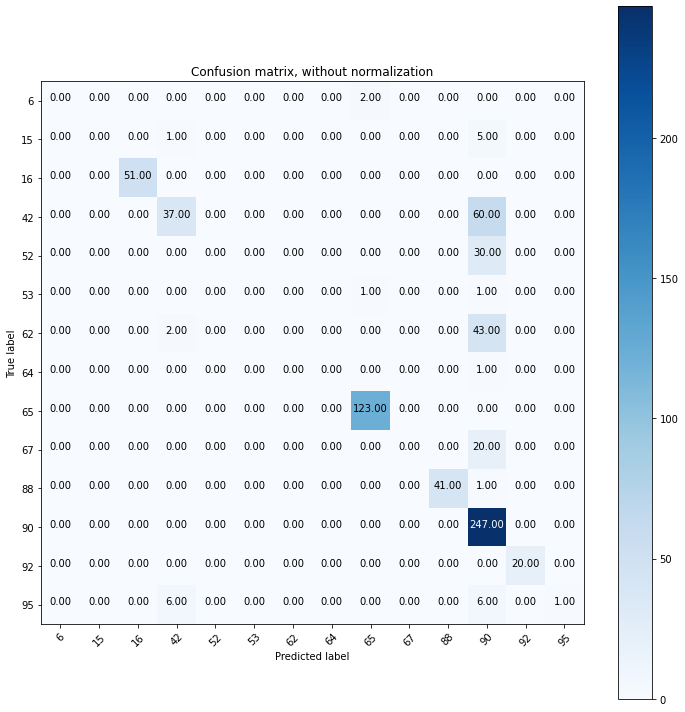

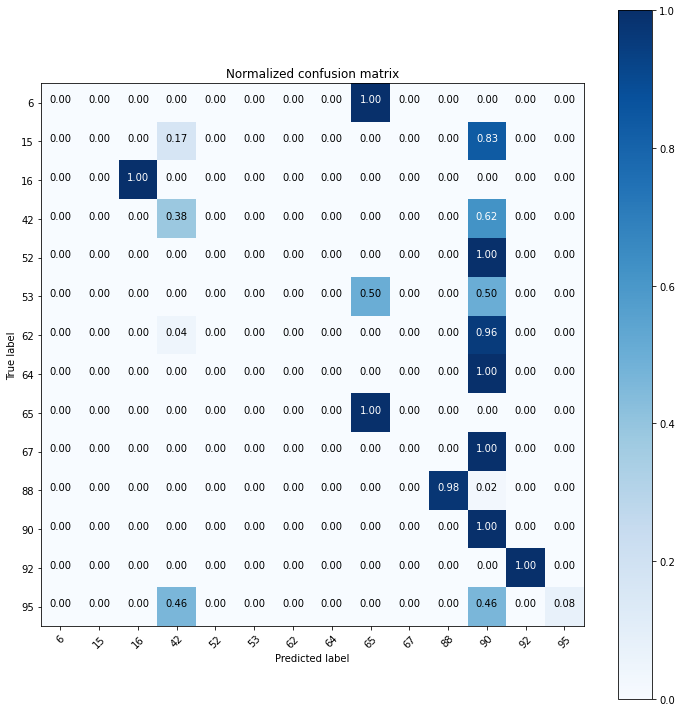

In [0]:
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_testddf, clfddf.predict(X_testddf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix');

plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


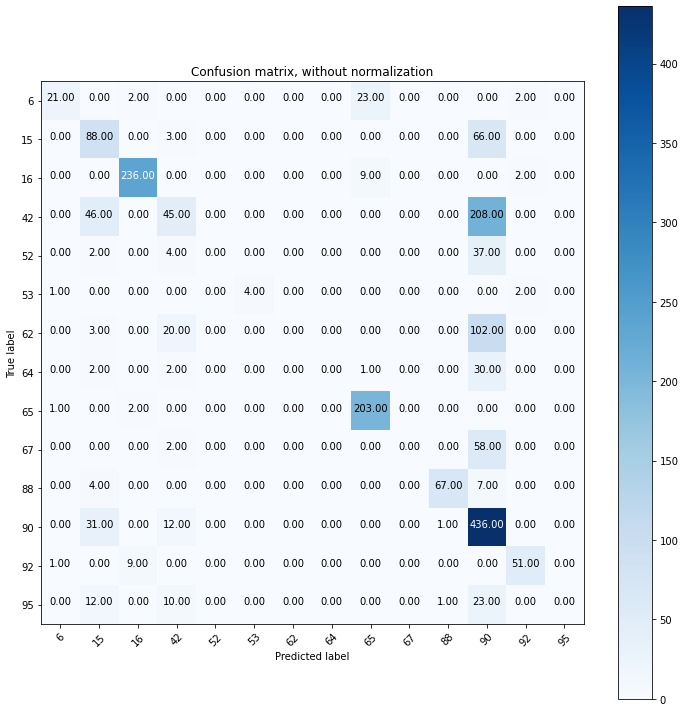

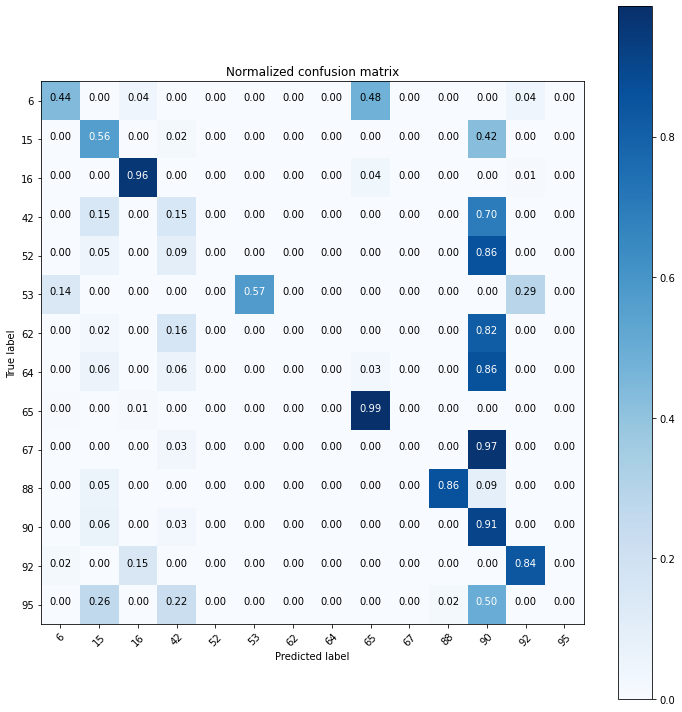

In [0]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_testnormal, clfnormal.predict(X_testnormal))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# TASK II.7 take a stab at interpreting this. We will discuss in class how to read this properly on tuesday

#Based on my quick reading of stuff on the internet and under the assumption that things on internet are always true, confusion matrix is a way to quantify the miscalssification of data based on a true given data, where the diagonal elements tells you how good the classification is. Looking at the normalized confusion matrix, this would mean that for example for bin 92, all the elements were correctly classified in the same bin, whereas almost half of elements (46%)belonging to bin 95 were mis-classified in bin 90 and another half were mis-classified in bin 42. Only 8% of all the labels were correctly classified to the same bin. So on for the other bins.

# Extra Credit IV: build a confusion matrix for yout gradient boosted tree model and comment on the result

In [0]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
clfddf_gb = GradientBoostingClassifier(loss='deviance', learning_rate=0.1,
                        n_estimators=100, subsample=1., 
                        criterion='friedman_mse', random_state=42).fit(X_trainddf, y_trainddf)
clfnormal_gb = GradientBoostingClassifier(loss='deviance', learning_rate=0.1,
                        n_estimators=100, subsample=1., 
                        criterion='friedman_mse', random_state=42).fit(X_trainnormal, y_trainnormal)

CPU times: user 3min 5s, sys: 35.8 ms, total: 3min 5s
Wall time: 3min 5s


In [0]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf_gb.score(X_testddf, y_testddf),
           clfnormal_gb.score(X_testnormal, y_testnormal)))

Random Forest Classification
score on DDF 0.79 and on normal survey 0.68


Confusion matrix, without normalization
Normalized confusion matrix


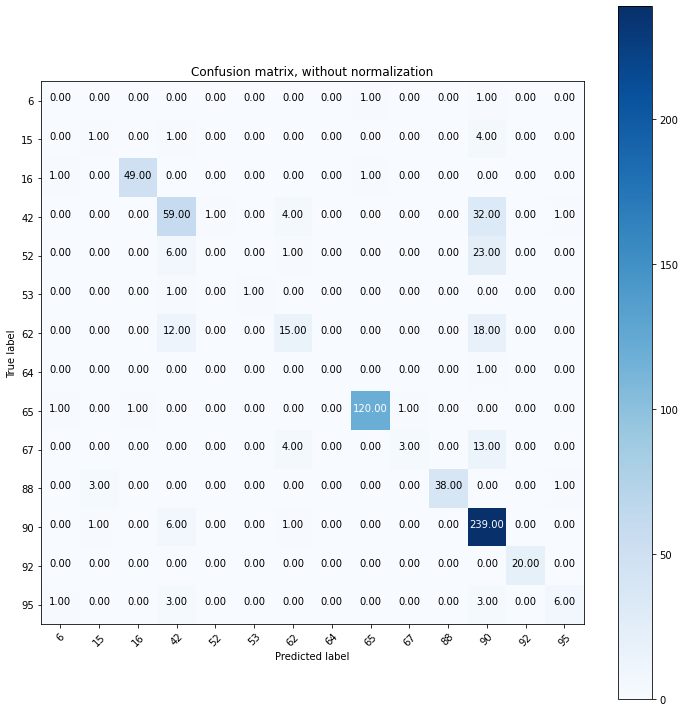

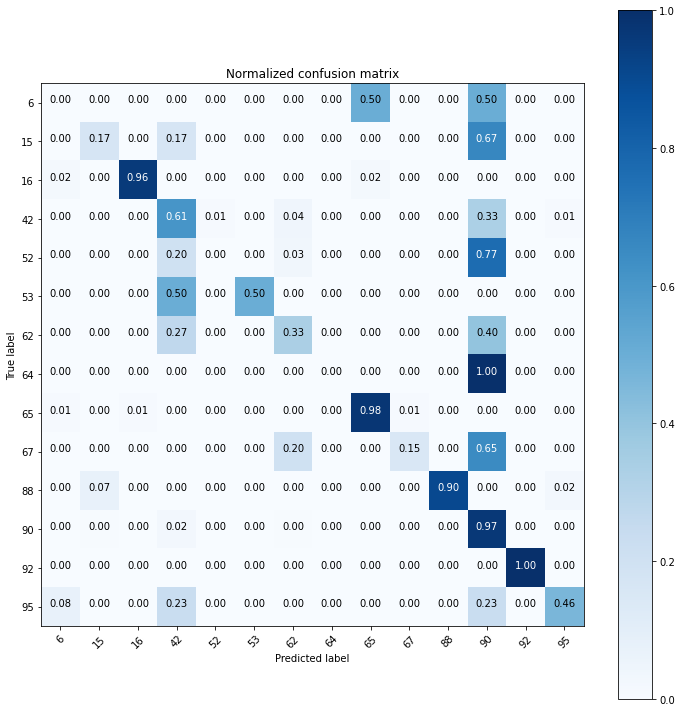

In [0]:
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_testddf, clfddf_gb.predict(X_testddf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


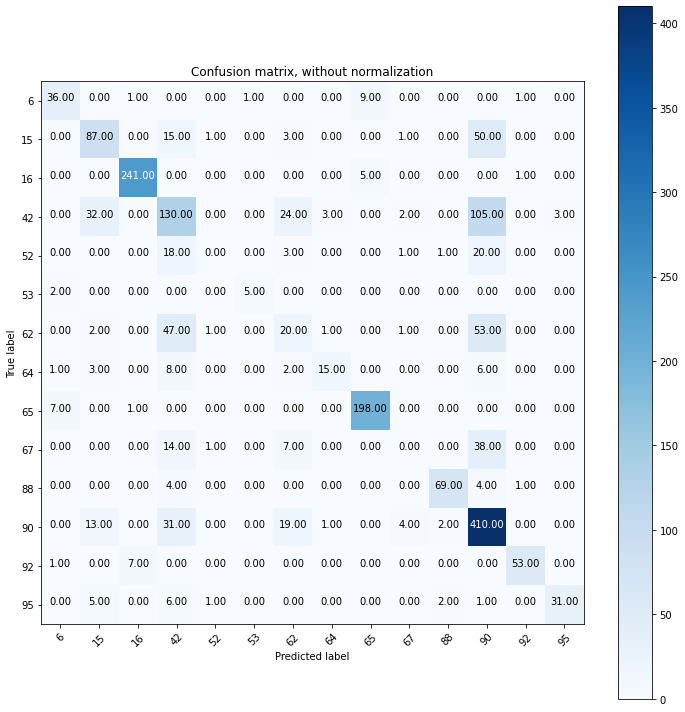

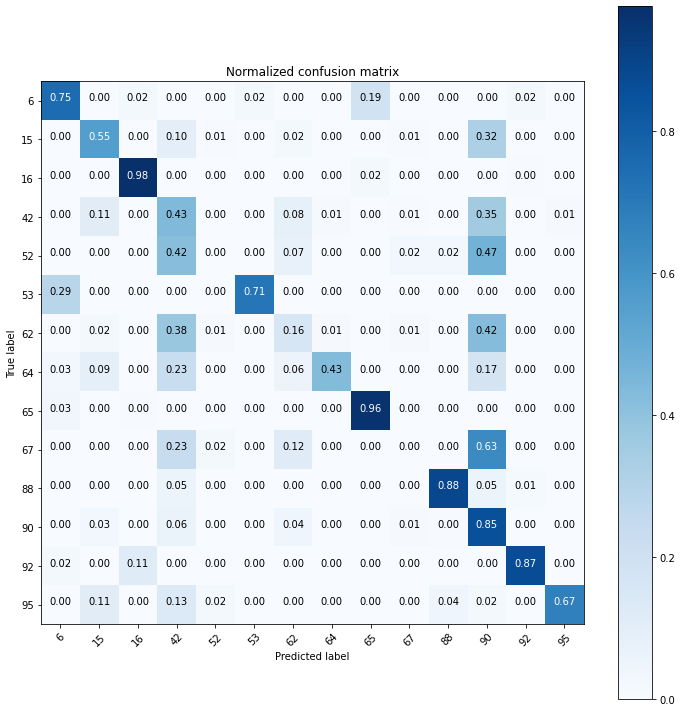

In [0]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_testnormal, clfnormal_gb.predict(X_testnormal))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# The confusion matrix for the Gradient Boosted trees seem to be doing a much beter job of proper or correct classification of labels as seen from the higher values of diagonal elements of the confusion matrix. 